# Test Linear Regression

This notebook is an example that will test the generalization capability of a regression to word vectors. There are three corpora involved.

## Required Data

1. The _word vector corpora_
  * Examples: New York Times, Wikipedia Text8
  * Data: Pretrained word vectors (word2vec, etc.)
2. The _training corpora_
  * Examples: IAPR-TC12, MSCOCO, Visual Genome
  * Data:
    - Training image features and text labels
    - Testing image features and text labels <-- Used as validation data
3. A _testing corpora_ with a different vocabulary
  * Examples: MSCOCO, Visual Genome, etc.
  * Data: Training and testing image features


### Imports

In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys

## Should probably update to PYTHONPATH
sys.path.append('/data/fs4/home/kni/attalos/')
# ls /data/fs4/home/kni/attalos/
from attalos.dataset.dataset import Dataset
imdir = '/data/fs4/teams/attalos/features/image/'
txdir = '/data/fs4/teams/attalos/features/text/'

## Import word vector load in
import attalos.imgtxt_algorithms.util.readw2v as rw2v

## Import linear regression
import attalos.imgtxt_algorithms.linearregression.LinearRegression as linreg

## Import evaluation code (right now, using Octave soft evaluation)
# from attalos.evaluation.evaluation import Eval
from oct2py import octave
octave.addpath('../evaluation/')

reload(linreg)
%matplotlib inline

### Load the word vectors in

In [2]:
F = rw2v.ReadW2V('/data/fs4/teams/attalos/wordvecs/text9Bvin.bin')
vectors = F.readlines()

### Load training corpora in

In [3]:
train_dataset = Dataset(imdir+'iaprtc12_train_inception.hdf5', txdir+'iaprtc12_train_text.json.gz')
test_dataset = Dataset(imdir+'iaprtc12_test_inception.hdf5', txdir+'iaprtc12_test_text.json.gz')

In [4]:
D = open('linearregression/data/iaprtc_dictionary.txt').read().splitlines()
reverse_D = dict()
for i in range(len(D)): reverse_D[D[i]] = i 
    
xTr, yTrWds = train_dataset.get_next_batch(17565)
xTe, yTeWds = test_dataset.get_next_batch(1962)

In [5]:
data = np.load('linearregression/data/iaprtc_alexfc7.npz')
train_ims = [ im.split('/')[-1] for im in open('linearregression/data/iaprtc_trainlist.txt').read().splitlines() ]

test_ims_full = [ im for im in open('linearregression/data/iaprtc_testlist.txt').read().splitlines() ]
train_ims_full = [ im for im in open('linearregression/data/iaprtc_trainlist.txt').read().splitlines() ]

### Create probability distribution for words

bedcover: 15
table-cloth: 259
tee-shirt: 261


<Container object of 3 artists>

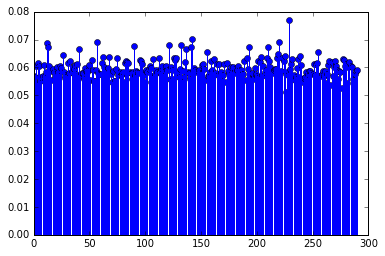

In [6]:
wordvecs = np.zeros((len(D), 200))
for i, word in enumerate(D):
    if vectors.has_key( word ):
        wordvecs[i] = vectors[word]
    else:
        print "{}: {}".format(word,i)
        
distvecs = 1 / (1 + np.exp( - 0.1*wordvecs.dot(wordvecs.T) ) )
# distvecs = np.tanh( 0.1*wordvecs.dot(wordvecs.T) )
distvecs = distvecs / np.linalg.norm( distvecs, axis=1 )

wdvecs=dict()
for i, word in enumerate(D):
    wdvecs[word] = distvecs[i]
    
plt.stem( wdvecs['shore'] )

### Convert multi-hot vectors to distribution vectors

1. wordvecs -> distvecs
2. onehot -> distvecs

### Convert all images in the training set to distribution vectors

In [7]:
yTr = np.zeros( (len(yTrWds), len(D)) )
for i, imtaglist in enumerate(yTrWds):
    for tag in imtaglist:
        # if tag in ['tee-shirt','bedcover','table-cloth']:
        #     continue
        yTr[i]+=wdvecs[tag]
    if yTr[i].sum() == 0:
        print "vector "+str(i)+" has no tags"

In [8]:
yTe = np.zeros( (len(yTeWds), len(D)) )
for i, imtaglist in enumerate(yTeWds):
    for tag in imtaglist:
        yTe[i,reverse_D[tag]] = 1

### Load testing corpora in


-------------------------------

### Train and validate

In [9]:
print xTr.shape
print yTr.shape
mp_solution = linreg.LinearRegression(normX = True, normY = True)
mp_solution.train(xTr, yTr)
yHat = mp_solution.predict(xTe)

(17565, 2048)
(17565, 291)
Building W matrix = Y \ X = Y^T X (X X^T)^-1


### Test

### Evaluate the regression

In [10]:
[precision, recall, f1score] = octave.evaluate(yTe.T, yHat.T, 5)
print precision
print recall
print f1score

0.234626174307
0.230973034904
0.232785273152


### Visualize

Looking at the 121th image: linearregression/images/02/2843.jpg
Predicted: 
Truth:     desert, front, man, middle, plane, woman


<Container object of 3 artists>

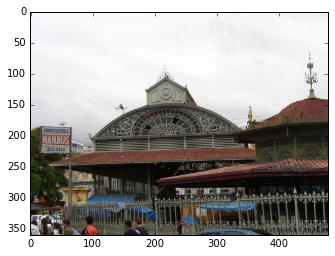

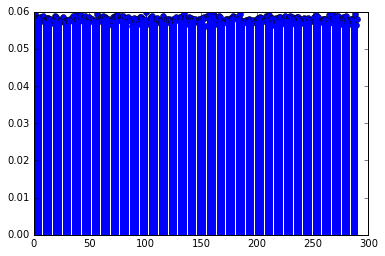

In [11]:
# Randomly select an image
i=np.random.randint(0, yTe.shape[1])

# Run example
imname='linearregression/images/'+test_ims_full[i]+'.jpg';
print "Looking at the "+str(i)+"th image: "+imname
im=plt.imread(imname)

# Prediction
ypwords = [D[j] for j in yHat[i].argsort()[::-1] [ 0:(yHat[i]>0.2).sum() ] ]
# Truth
ytwords = [D[j] for j in np.where(yTe[i] > 0.5)[0] ]

plt.imshow(im)
print 'Predicted: '+ ', '.join(ypwords)
print 'Truth:     '+ ', '.join(ytwords)

plt.figure()
plt.stem( yHat[i] )